In [40]:

#Bollinger Band reversion strategy 

# Importing necessary libraries

import yfinance as yf 
import pandas as pd
import numpy as np
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import pyfolio as pf
import os
import datetime as dt 


In [41]:
# Fetch data using yfinance
ticker = yf.Ticker("AAPL")
df = ticker.history(period="60d", interval="15m")
dataf = pd.DataFrame()

In [42]:
print(df)

                                 Open        High         Low       Close  \
Datetime                                                                    
2022-10-12 09:30:00-04:00  139.130005  140.149994  138.669998  140.099106   
2022-10-12 09:45:00-04:00  140.214996  140.240005  139.460007  139.893707   
2022-10-12 10:00:00-04:00  139.899994  140.199997  139.199997  139.210007   
2022-10-12 10:15:00-04:00  139.210007  139.835007  138.854996  139.675003   
2022-10-12 10:30:00-04:00  139.669998  139.960007  138.985001  139.000000   
...                               ...         ...         ...         ...   
2023-01-06 15:00:00-05:00  129.850006  130.289993  129.809998  129.994995   
2023-01-06 15:15:00-05:00  130.000000  130.115005  129.699997  129.809998   
2023-01-06 15:30:00-05:00  129.815002  130.050003  129.755005  129.800598   
2023-01-06 15:45:00-05:00  129.800003  129.970001  129.339996  129.520004   
2023-01-06 16:00:00-05:00  129.619995  129.619995  129.619995  129.619995   

In [43]:
# calculating buy and hold strategy returns
df['bh_returns'] = np.log(df['Close']/df['Close'].shift(1))
df.head(3)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,bh_returns
Datetime,,,,,,,,
2022-10-12 09:30:00-04:00,139.130005,140.149994,138.669998,140.099106,7161307,0.0,0,NaN
2022-10-12 09:45:00-04:00,140.214996,140.240005,139.460007,139.893707,3480590,0.0,0,-0.001467
2022-10-12 10:00:00-04:00,139.899994,140.199997,139.199997,139.210007,3342311,0.0,0,-0.004899


In [44]:
# creating bollinger band indicators
df['ma20'] = df['Close'].rolling(window=20).mean()
df['std'] = df['Close'].rolling(window=20).std()
df['upper_band'] = df['ma20'] + (2 * df['std'])
df['lower_band'] = df['ma20'] - (2 * df['std'])
df.drop(['Open','High','Low'],axis=1,inplace=True,errors='ignore')
df.tail(5)

,Close,Volume,Dividends,Stock Splits,bh_returns,ma20,std,upper_band,lower_band
Datetime,,,,,,,,,
2023-01-06 15:00:00-05:00,129.994995,3301379,0.0,0,0.001123,128.263665,0.997409,130.258482,126.268848
2023-01-06 15:15:00-05:00,129.809998,2447682,0.0,0,-0.001424,128.435415,0.949675,130.334766,126.536065
2023-01-06 15:30:00-05:00,129.800598,2866284,0.0,0,-0.000072,128.572945,0.937574,130.448093,126.697797
2023-01-06 15:45:00-05:00,129.520004,7056065,0.0,0,-0.002164,128.678445,0.918343,130.515131,126.841759
2023-01-06 16:00:00-05:00,129.619995,0,0.0,0,0.000772,128.790445,0.887735,130.565915,127.014975


In [45]:
# BUY TRIGGER
df['signal'] = np.where((df['Close'] < df['lower_band']) &
                        (df['Close'].shift(1) >=       df['lower_band']),1,0)

In [46]:
# SELL TRIGGER
df['signal'] = np.where( (df['Close'] > df['upper_band']) &
                          (df['Close'].shift(1) <= df['upper_band']),-1,df['signal'])

In [47]:
# Initiating Long and Short Trade  
df['position'] = df['signal'].replace(to_replace=0, method='ffill')

In [48]:
# Shifting by 1 taking into account the close price return calculations
df['position'] = df['position'].shift(1)

In [49]:
# calculating strategy returns
df['strategy_returns'] = df['bh_returns'] * (df['position'])
df.tail(5)
df.head(10)

,Close,Volume,Dividends,Stock Splits,bh_returns,ma20,std,upper_band,lower_band,signal,position,strategy_returns
Datetime,,,,,,,,,,,,
2022-10-12 09:30:00-04:00,140.099106,7161307,0.0,0,NaN,NaN,NaN,NaN,NaN,0,NaN,NaN
2022-10-12 09:45:00-04:00,139.893707,3480590,0.0,0,-0.001467,NaN,NaN,NaN,NaN,0,0.0,-0.0
2022-10-12 10:00:00-04:00,139.210007,3342311,0.0,0,-0.004899,NaN,NaN,NaN,NaN,0,0.0,-0.0
2022-10-12 10:15:00-04:00,139.675003,2819202,0.0,0,0.003335,NaN,NaN,NaN,NaN,0,0.0,0.0
2022-10-12 10:30:00-04:00,139.000000,2682738,0.0,0,-0.004844,NaN,NaN,NaN,NaN,0,0.0,-0.0
2022-10-12 10:45:00-04:00,139.429993,2298289,0.0,0,0.003089,NaN,NaN,NaN,NaN,0,0.0,0.0
2022-10-12 11:00:00-04:00,139.429993,2653917,0.0,0,0.000000,NaN,NaN,NaN,NaN,0,0.0,0.0
2022-10-12 11:15:00-04:00,139.679993,1899783,0.0,0,0.001791,NaN,NaN,NaN,NaN,0,0.0,0.0
2022-10-12 11:30:00-04:00,139.970001,2081896,0.0,0,0.002074,NaN,NaN,NaN,NaN,0,0.0,0.0


Buy and Hold returns: -0.07774301565890754
Strategy returns: -0.0011532164557492314


<AxesSubplot: xlabel='Datetime'>

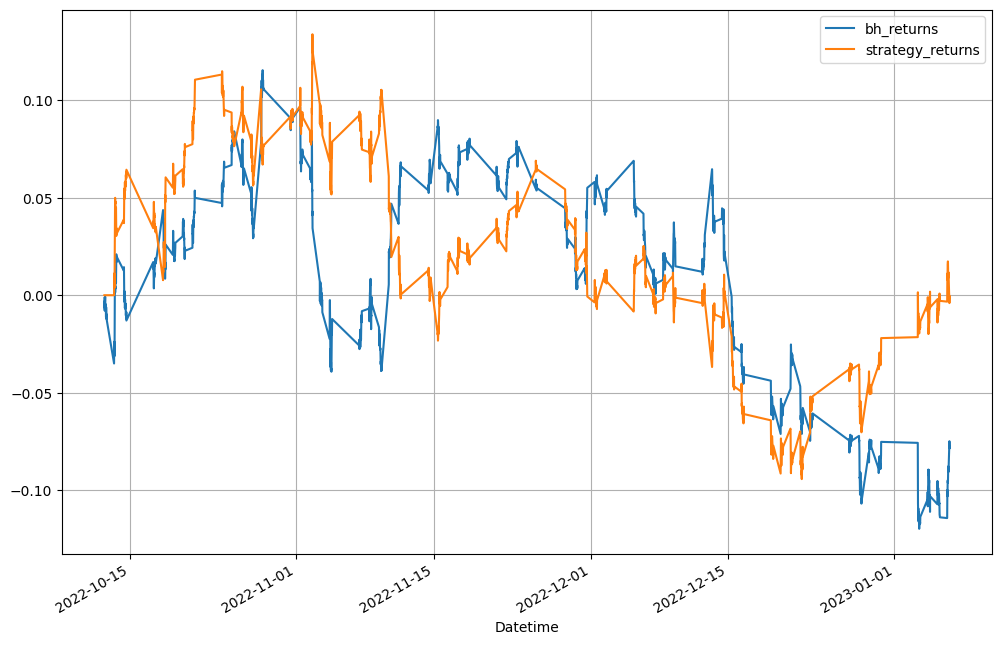

In [50]:
# comparing buy & hold strategy / bollinger bands strategy returns
print("Buy and Hold returns:",df['bh_returns'].cumsum()[-1])
print("Strategy returns:",df['strategy_returns'].cumsum()[-1])

# plotting strategy historical performance over time
df[['bh_returns','strategy_returns']] = df[['bh_returns','strategy_returns']].cumsum()
df[['bh_returns','strategy_returns']].plot(grid=True, figsize=(12, 8))

c:\Users\Wolfrank\Desktop\Wolf Code\.venv\lib\site-packages\pyfolio\timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
c:\Users\Wolfrank\Desktop\Wolf Code\.venv\lib\site-packages\pyfolio\plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2022-10-12
End date,2023-01-06
Total months,73
,Backtest
Annual return,-0.3%
Cumulative returns,-1.7%
Annual volatility,7.1%
Sharpe ratio,-0.00
Calmar ratio,-0.01
Stability,0.64
Max drawdown,-21.1%


c:\Users\Wolfrank\Desktop\Wolf Code\.venv\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


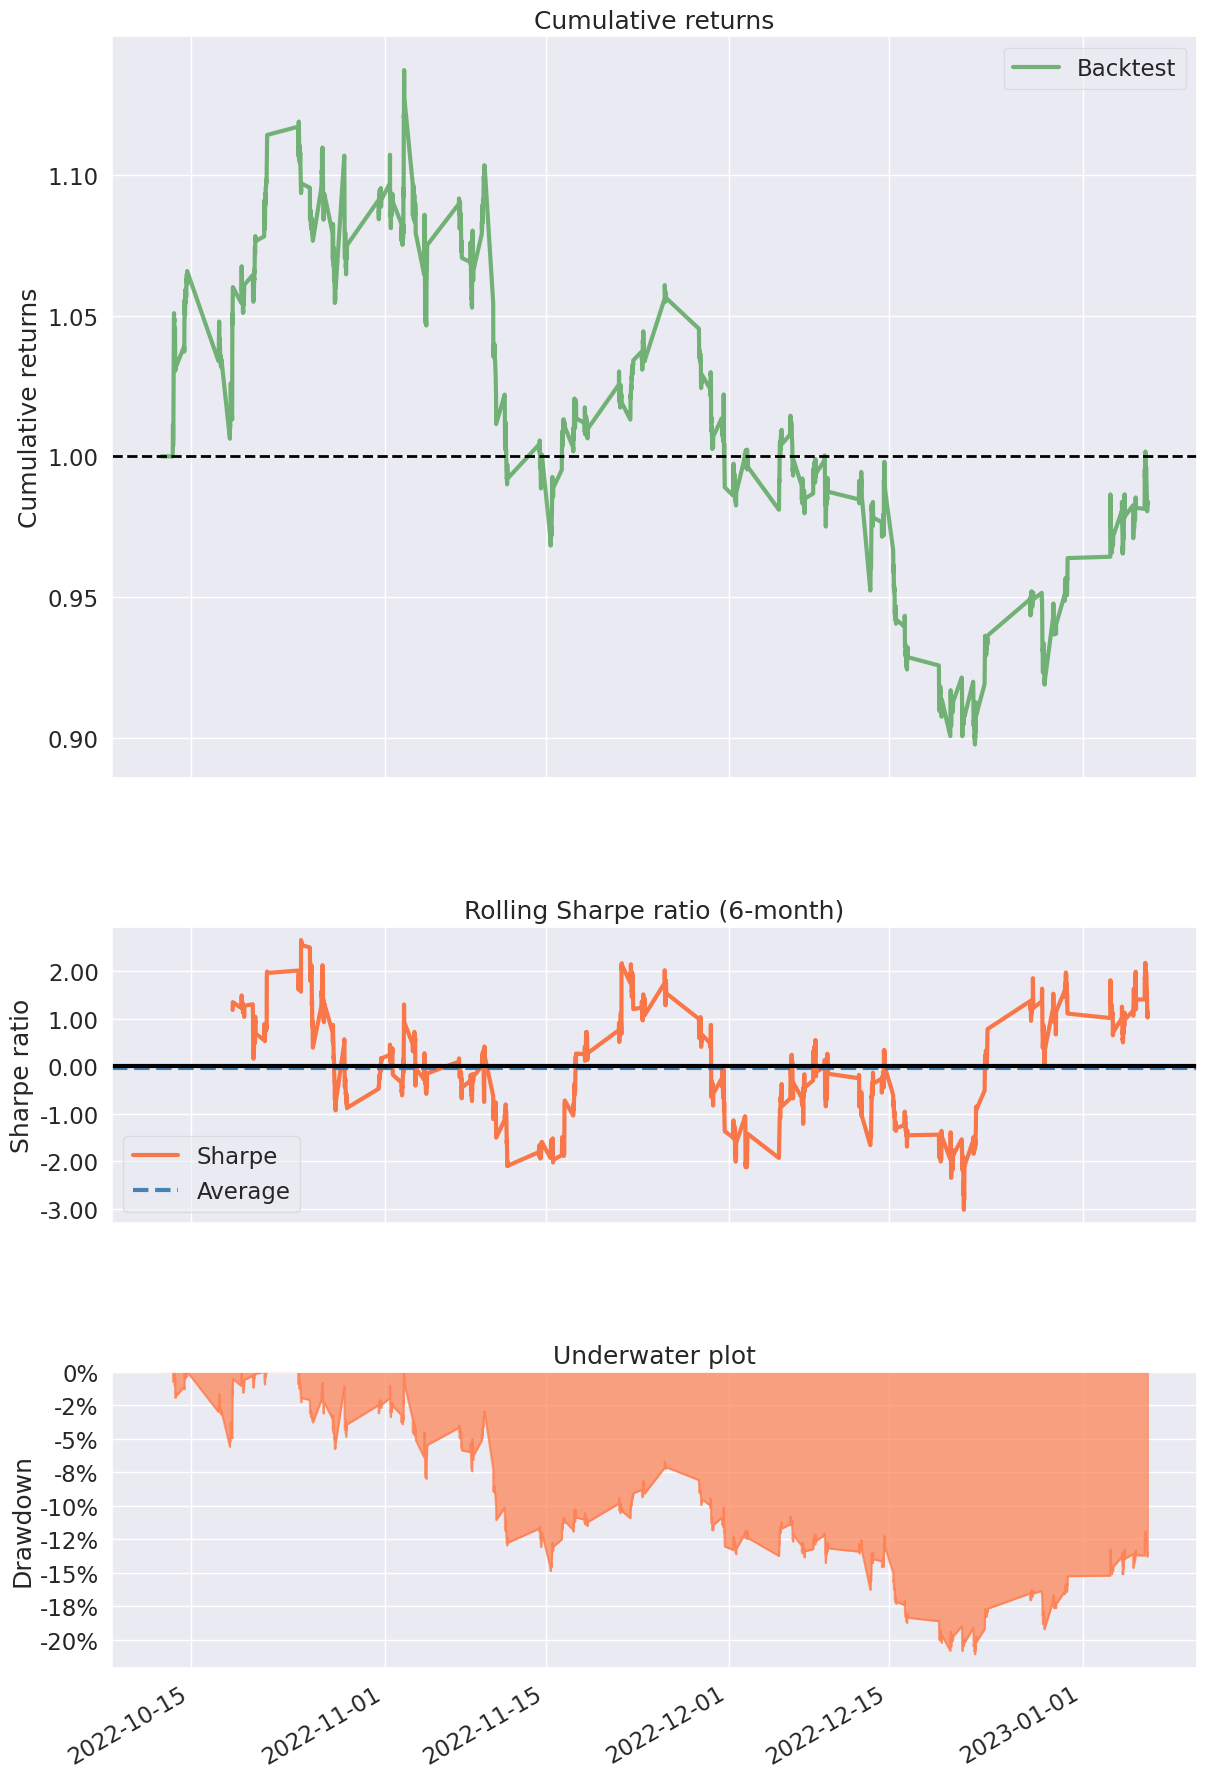

In [51]:
pf.create_simple_tear_sheet(df['strategy_returns'].diff())
